# RX Sensitivity Training

TODO:
1. Find meta model to handle missing input values
    - Add filter to remove all null rows in train or test data in default train fn
2. Add matrix completion or MICE as imputation for Y_train
3. Add RPPA predictions to meta model inputs
4. Convert this to a script so that multiprocessing can be used?
5. Set up storage of predictions for different experiments so that progress can be documented well

In [1]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_seaborn
%matplotlib inline
from mgds.data_aggregation import api
from mgds.data_aggregation import database as db
from mgds.data_aggregation import source as src
from mgds.data_aggregation import data_type as dtyp
from mgds.data_aggregation import entity
from mgds.data_modeling import data_broker as dbm
from mgds.data_modeling import training01 as rx_train
from py_utils import collection_utils

In [2]:
entity_mappings={
    entity.CELL_LINE: api.get_entity_mapping(entity.CELL_LINE),
    entity.PRIMARY_SITE: api.get_entity_mapping(entity.PRIMARY_SITE)
}

In [3]:
df = api.get_raw_genomic_data(src.GDSC_v2, dtyp.DRUG_SENSITIVITY, mappings=entity_mappings)
df['INDICATOR'] = 1

In [4]:
df.head()

,IC50_RESULTS_ID,CELL_LINE_ID:COSMIC,DRUG_ID:COSMIC,MAX_CONC_MICROMOLAR,LN_IC50,AUC,RMSE,DRUG_NAME,SYNONYMS,TARGET,TARGET_PATHWAY,CELL_LINE_ID,CELL_LINE_ID:MGDS,PRIMARY_SITE:MGDS,PRIMARY_SITE:SOURCE,DRUG_NAME:MGDS,DRUG_NAME:SOURCE,INDICATOR
0,335,924100,1026,1.0,0.717722,0.899410,0.105665,17-AAG,tanespimycin,HSP90,other,22RV1,22RV1,PROSTATE,PROSTATE,17AAG,17-AAG,1
1,336,924100,1028,2.0,2.664100,0.957206,0.178243,VX-702,NaN,p38,JNK and p38 signaling,22RV1,22RV1,PROSTATE,PROSTATE,VX702,VX-702,1
2,337,924100,1029,2.0,3.336828,0.973893,0.079845,AMG-706,AMG-706,"VEGFR, RET, c-KIT, PDGFR",RTK signaling,22RV1,22RV1,PROSTATE,PROSTATE,AMG706,AMG-706,1
3,338,924100,1030,10.0,5.164909,0.977844,0.094228,KU-55933,NaN,ATM,Genome integrity,22RV1,22RV1,PROSTATE,PROSTATE,KU55933,KU-55933,1
4,339,924100,1031,0.2,-4.325309,0.508180,0.090478,Elesclomol,NaN,HSP70,other,22RV1,22RV1,PROSTATE,PROSTATE,ELESCLOMOL,Elesclomol,1


In [54]:
df[df['CELL_LINE_ID:MGDS'].isnull()]

,IC50_RESULTS_ID,CELL_LINE_ID:COSMIC,DRUG_ID:COSMIC,MAX_CONC_MICROMOLAR,LN_IC50,AUC,RMSE,DRUG_NAME,SYNONYMS,TARGET,TARGET_PATHWAY,CELL_LINE_ID,CELL_LINE_ID:MGDS,PRIMARY_SITE:MGDS,PRIMARY_SITE:SOURCE,DRUG_NAME:MGDS,DRUG_NAME:SOURCE,INDICATOR
10420,10929,1295743,133,1.024,-0.393864,0.825113,0.064304,Doxorubicin,"Doxil,Rubex",DNA intercalating,DNA replication,NaN,NaN,NaN,NaN,DOXORUBICIN,Doxorubicin,1
10421,10930,1295743,134,16.000,2.463434,0.836353,0.101059,Etoposide,NaN,TOP2,DNA replication,NaN,NaN,NaN,NaN,ETOPOSIDE,Etoposide,1
10422,10931,1295743,135,1.024,-4.909897,0.196123,0.233212,Gemcitabine,"Gemzar, LY-188011",DNA replication,DNA replication,NaN,NaN,NaN,NaN,GEMCITABINE,Gemcitabine,1
10423,10932,1295743,136,16.000,-0.369951,0.442999,0.041157,Mitomycin C,"Mytozytrex,NSC-26980",DNA crosslinker,DNA replication,NaN,NaN,NaN,NaN,MITOMYCIN,Mitomycin C,1
10424,10933,1295743,140,0.064,-2.046091,0.918537,0.080427,Vinorelbine,NaN,Microtubules,cytoskeleton,NaN,NaN,NaN,NaN,VINORELBINE,Vinorelbine,1
10425,10934,1295743,147,16.000,4.532865,0.965164,0.066584,NSC-87877,NaN,"SHP-1 (PTPN6), SHP-2 (PTPN11)",other,NaN,NaN,NaN,NaN,NSC87877,NSC-87877,1
10426,10936,1295743,151,10.240,3.818080,0.956397,0.056809,QS11,QS11,ARFGAP,other,NaN,NaN,NaN,NaN,QS11,QS11,1
10427,10937,1295743,152,16.000,1.192698,0.679236,0.135254,CP466722,"[2-(6,7-dimethoxyquinazolin-4-yl)-5-(pyridin-2...",ATM,Genome integrity,NaN,NaN,NaN,NaN,CP466722,CP466722,1
10428,10938,1295743,153,0.512,-0.574110,0.874138,0.097488,Midostaurin,PKC 412,KIT,RTK signaling,NaN,NaN,NaN,NaN,MIDOSTAURIN,Midostaurin,1
10429,10940,1295743,155,0.512,-0.075940,0.911611,0.084367,AP-24534,KIN001-192,ABL,ABL signaling,NaN,NaN,NaN,NaN,AP24534,AP-24534,1


In [28]:
df.groupby(['CELL_LINE_ID:MGDS', 'GENE_ID:HGNC', 'VALUE']).size().value_counts()
#df.groupby(['CELL_LINE_ID:MGDS', 'GENE_ID:HGNC', 'INDICATOR']).size().value_counts()

1    17000944
dtype: int64

In [29]:
df.groupby(['CELL_LINE_ID:MGDS', 'GENE_ID:HGNC']).size().value_counts()

1    17000944
dtype: int64

In [29]:
import imp
imp.reload(api)

<module 'mgds.data_aggregation.api' from '/Users/eczech/repos/mgds/python/src/mgds/data_aggregation/api.py'>

In [22]:
datasets = api.get_genomic_data_availability()
datasets = [v for v in datasets if v[1] == dtyp.DRUG_SENSITIVITY]
datasets

[('gdsc_v2', 'drug-sensitivity'),
 ('ccle_v1', 'drug-sensitivity'),
 ('nci60_v2', 'drug-sensitivity'),
 ('ncidream_v1', 'drug-sensitivity')]

In [3]:
from py_utils.pandas_utils import one_value

def get_feature_datasets(dataset_info):
    d = []
    m = []
    for (source, data_type) in dataset_info:
        logger.info('Unpacking source "{}", data set "{}"'.format(source, data_type))

        c_val = 'INDICATOR' if data_type in [dtyp.GENE_EXOME_SEQ] else 'VALUE'
        c_col = 'GENE_ID:HGNC' if data_type != dtyp.DRUG_SENSITIVITY else 'DRUG_NAME:MGDS'
        agg_func = 'mean' if data_type in [dtyp.GENE_EXOME_SEQ, dtyp.DRUG_SENSITIVITY] else one_value

        # Leaving this out due to lack of clarity on encoding (what is "-1,-1,-,-"?)
        if source == src.GDSC_v2 and data_type in [dtyp.GENE_COPY_NUMBER]:
            continue

        # These were both verified to show that the values associated with all duplicate MGDS cell lines
        # and genes are identical (so the mean will be used, but there is no variance)
        if source == src.CCLE_v1 and data_type in [dtyp.GENE_COPY_NUMBER, dtyp.GENE_EXPRESSION]:
            agg_func = 'mean'

        # If sensitivity data is being loaded, determine which measurement is preferred for this
        # particular source and assign that as the value to aggregate
        if data_type == dtyp.DRUG_SENSITIVITY:
            drug_measures = api.get_preferred_drug_sensitivity_measurements()
            if source not in drug_measures:
                raise ValueError(
                    'Source "{}" does not have a preferred sensitivity measurement assigned yet'
                    .format(source)
                )
            c_val = drug_measures[source]

        df = api.get_raw_genomic_data(source, data_type, mappings=entity_mappings)
        df['INDICATOR'] = 1
        
        if c_val == 'VALUE' and 'VALUE' not in df:
            c_val = 'VALUE_MEAN'


        
        na_cell_line = df['CELL_LINE_ID:MGDS'].isnull()
        if na_cell_line.any():
            df = collection_utils.subset(
                df, lambda data: data[~na_cell_line], 
                subset_op='Removing records with null MGDS cell line ID',
                log=logger
            )
            
        c_primary_site = 'PRIMARY_SITE:MGDS:{}:{}'.format(source, data_type)
        m.append((
            df
                .filter(items=['CELL_LINE_ID:MGDS', 'PRIMARY_SITE:MGDS'])
                .drop_duplicates()
                .rename(columns={'PRIMARY_SITE:MGDS': c_primary_site})
                .set_index('CELL_LINE_ID:MGDS')  
        ))
            
        df = df.drop('PRIMARY_SITE:MGDS', axis=1).pivot_table(
            index='CELL_LINE_ID:MGDS',
            columns=c_col,
            values=c_val,
            aggfunc=agg_func
        )
        df.columns = pd.MultiIndex.from_tuples([(source, data_type, c) for c in df])
        d.append(df)
        
    def get_site(r):
        rd = r.dropna()
        if rd.nunique() > 1:
            raise ValueError('Found primary site combinations with conflicting values; row = "{}"'.format(r))
        return rd.iloc[0] if len(rd) > 0 else None
    primary_sites = pd.concat(m, axis=1).apply(get_site, axis=1).fillna('NULL')
    
    d = pd.concat(d, axis=1)
    d.index = d.index.set_names('CELL_LINE_ID:MGDS')
    d['PRIMARY_SITE:MGDS'] = d.index.to_series().map(primary_sites)
    d = d.set_index('PRIMARY_SITE:MGDS', append=True)
    
    return d

datasets = api.get_genomic_data_availability()
#datasets = [v for v in datasets if v[1] == dtyp.DRUG_SENSITIVITY]

#d = get_feature_datasets(datasets)
d = db.cache_prep_operation(lambda: get_feature_datasets(datasets), 'raw-features', overwrite=False)

2017-01-23 12:48:41,330:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/mgds_v1_raw-features.pkl"


In [5]:
d.head()

ccle_v1                   \
                                         gene-copy-number                    
                                                     A1BG A1BG-AS1    A1CF   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                          
1321N1            CENTRAL_NERVOUS_SYSTEM          -0.1544  -0.1544 -0.0985   
143B              BONE                            -0.2120  -0.2120  0.1580   
184A1             BREAST                              NaN      NaN     NaN   
184B5             BREAST                              NaN      NaN     NaN   
2004              NULL                                NaN      NaN     NaN   

                                                                          \
                                                                           
                                             A2M   A2ML1  A4GALT   A4GNT   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                        
1321N1            CENTRAL_NERVOUS_SYSTEM -0.1819 -0.1819 -0.1732  0.2575   
143B              BONE                   -0.1753 -0.1753 -0.2536  0.2060   
184A1             BREAST                     NaN     NaN     NaN     NaN   
184B5             BREAST                     NaN     NaN     NaN     NaN   
2004              NULL                       NaN     NaN     NaN     NaN   

                                                                    ...     \
                                                                    ...      
                                            AAAS    AACS  AACSP1    ...      
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                 ...      
1321N1            CENTRAL_NERVOUS_SYSTEM -0.0404 -0.1284  0.1682    ...      
143B              BONE                   -0.1445 -0.2757  0.2150    ...      
184A1             BREAST                     NaN     NaN     NaN    ...      
184B5             BREAST                     NaN     NaN     NaN    ...      
2004              NULL                       NaN     NaN     NaN    ...      

                                              ncidream_v1                    \
                                         drug-sensitivity                     
                                                    MG132 MG132B NELFINAVIR   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                           
1321N1            CENTRAL_NERVOUS_SYSTEM              NaN    NaN        NaN   
143B              BONE                                NaN    NaN        NaN   
184A1             BREAST                         2.044571    NaN   1.700421   
184B5             BREAST                         2.052219    NaN   1.673305   
2004              NULL                                NaN    NaN        NaN   

                                                                            \
                                                                             
                                         NILONTINIB OLOMOUCINEII    PS1145   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                          
1321N1            CENTRAL_NERVOUS_SYSTEM        NaN          NaN       NaN   
143B              BONE                          NaN          NaN       NaN   
184A1             BREAST                   1.308054     1.704059  1.001932   
184B5             BREAST                   1.308054     1.709954  1.001932   
2004              NULL                          NaN          NaN       NaN   

                                                                          \
                                                                           
                                               QNZ  TCSPIM11 TRASTUZUMAB   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS                                        
1321N1            CENTRAL_NERVOUS_SYSTEM       NaN       NaN         NaN   
143B              BONE                         NaN       NaN         NaN   
184A1             BREAST                  1.499077  1.640310    1.718021   
184B5       

In [6]:
def summarise_cols(name, cols):
    cts = pd.Series([':'.join(c[:2]) for c in cols]).value_counts()
    print('{}| Num levels = {}, Count by: {}'.format(name, cols.nlevels, cts))
summarise_cols('', d.columns)

| Num levels = 3, Count by: ncidream_v1:gene-rna-seq        30154
ncidream_v1:gene-copy-number    27230
nci60_v2:gene-copy-number       23367
nci60_v2:gene-expression        22370
ccle_v1:gene-copy-number        20381
gdsc_v2:gene-exome-seq          19100
ncidream_v1:gene-expression     18632
gdsc_v2:gene-expression         17419
ccle_v1:gene-expression         16042
ncidream_v1:gene-methylation    14475
ncidream_v1:gene-exome-seq      11995
nci60_v2:gene-exome-seq         11203
nci60_v2:drug-sensitivity        4210
ccle_v1:gene-exome-seq           2165
ctd_v2:drug-sensitivity           545
gdsc_v2:drug-sensitivity          251
ncidream_v1:drug-sensitivity       28
dtype: int64


In [7]:
sites = d.index.get_level_values('PRIMARY_SITE:MGDS')
sites.value_counts()

HAEMATOPOIETIC_AND_LYMPHOID_TISSUE    244
LUNG                                  230
SKIN                                   88
BREAST                                 86
CENTRAL_NERVOUS_SYSTEM                 77
LARGE_INTESTINE                        68
OVARY                                  66
BONE                                   61
UPPER_AERODIGESTIVE_TRACT              60
NULL                                   54
KIDNEY                                 53
PANCREAS                               49
STOMACH                                48
AUTONOMIC_GANGLIA                      39
OESOPHAGUS                             37
URINARY_TRACT                          30
ENDOMETRIUM                            29
LIVER                                  29
SOFT_TISSUE                            28
PLEURA                                 26
THYROID                                18
CERVIX                                 14
BILIARY_TRACT                          12
PROSTATE                          

In [7]:
cols = [v for v in api.get_genomic_data_availability() if v[1] == dtyp.DRUG_SENSITIVITY]
#d[cols].head()
#d[cols[:2]].head()
cols

[('gdsc_v2', 'drug-sensitivity'),
 ('ctd_v2', 'drug-sensitivity'),
 ('nci60_v2', 'drug-sensitivity'),
 ('ncidream_v1', 'drug-sensitivity')]

In [24]:
drugs = pd.Series([c[2] for c in d if c[1] == dtyp.DRUG_SENSITIVITY])
drugs.drop_duplicates().head()

0            17AAG
1    5FLUOROURACIL
2    5Z7OXOZEAENOL
3           681640
4          A443654
dtype: object

In [25]:
#test_drugs = ['NAVITOCLAX', 'NUTLIN3A']
test_drugs = ['NAVITOCLAX', 'NUTLIN3A', 'PLX4720', 'SB590885', 'AG014699']
[v for v in drugs if v in test_drugs]

['AG014699',
 'NAVITOCLAX',
 'NUTLIN3A',
 'PLX4720',
 'SB590885',
 'NAVITOCLAX',
 'PLX4720']

In [23]:
import imp
imp.reload(ml_feature_selection)

<module 'ml.sklearn.feature_selection' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/sklearn/feature_selection.py'>

In [57]:
#response_fields = [c for c in d if c[1] == dtyp.DRUG_SENSITIVITY]

from ml.sklearn import feature_selection as ml_feature_selection
from sklearn.feature_selection import f_regression, VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import MultiTaskLassoCV, MultiTaskLasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from py_utils import collection_utils

import pdb

def get_drug_sensitivity_selector(source):
    def selector(d):
        return [c for c in d if c[0] == source and c[1] == dtyp.DRUG_SENSITIVITY]
    return selector

def get_feature_selector(source, data_type, names=None):
    def selector(d):
        # summarize_cols('features', d.columns)
        feats = [c for c in d if c[0] == source and c[1] == data_type]
        if names is None:
            return feats
        cols = [c for c in feats if c[2] in names]
        assert len(cols) > 0, 'Feature selector resulted in empty set'
        return cols
    return selector

def get_default_train_fn(est_factory, imputer_factory=None):
    def train(X_train, Y_train, X_test, prefit_est):
        
        non_na_mask = Y_train.notnull().any(axis=1)
        if non_na_mask.any():
            n_after = np.sum(non_na_mask)
            n_before = len(Y_train)
            n_diff = n_before - n_after
#             logger.info(
#                 'Removing {} records of {} ({} %) in training data due to all NA responses'
#                 .format(n_diff, n_before, 100 * round(n_diff / n_before, 2))
#             )
            X_train = X_train[non_na_mask.values]
            Y_train = Y_train[non_na_mask.values]
            assert len(X_train) == len(Y_train) == n_after
        assert len(X_train) > 0
        
        # TODO: eliminate rows from X_test and Y_test if any are all null
        # TODO: make Y_train imputation better
        
        if imputer_factory is not None:
            y = imputer_factory().fit_transform(Y_train)
            Y_train = pd.DataFrame(y, index=Y_train.index, columns=Y_train.columns)
            
        if prefit_est is not None:
            est = prefit_est
        else:
            est = est_factory()
            est.fit(X_train, Y_train)
            
        Y_pred = None
        if X_test is not None: 
            Y_pred = pd.DataFrame(est.predict(X_test), index=X_test.index, columns=Y_train.columns)
        return est, Y_pred
    return train


# Test mode
# target_drugs = ['NAVITOCLAX', 'NUTLIN3A']
# target_genes = [
#     'A1BG', 'A1GB-AS1', 'A1CF', 'A2M', 'A2ML1',
#     'YAP1', 'WNK3', 'WHSC1L1', 'TNFRSF13B', 'PRKCB', 'PAX2', 'MNX1'
# ]

# Real targets
target_genes = None
target_drugs = ['NAVITOCLAX', 'NUTLIN3A', 'PLX4720', 'SB590885', 'AG014699']


# target_drugs = ['Navitoclax', 'Nutlin', 'AG-014699', 'PD-0332991', 'PLX4720', 'SB590885']

# rf_factory = lambda: Pipeline([
#     ('impute', Imputer()), 
#     ('est', RandomForestRegressor())
# ])
# knn_factory = lambda: Pipeline([
#     ('impute', Imputer()), 
#     ('scale', RobustScaler()), 
#     ('est', KNeighborsRegressor())
# ])
 
def_imputer_factory = lambda: Imputer()
zero_imputer_factory = lambda: FunctionTransformer(func=lambda X: np.nan_to_num(X), validate=False)


def regressor_factory(estimator_factory, discrete=False, k=1000, scale=True, 
                      select=True, imputer_factory=def_imputer_factory):
    def create_pipeline():
        steps = []
        steps = [('impute', imputer_factory())]
        steps += [('nzv', VarianceThreshold())]
        if scale:
            steps += [('scale', RobustScaler())]
        if select:
            # TODO: Modify this to also support discrete features; f_regression is ok for continuous
            # and ordered categorical/binary but less so for unordered categorical (so maybe that's ok?)
            base_selector = ml_feature_selection.SelectKBest(f_regression, k=k, validate=False)
            selector = ml_feature_selection.MultiOutputSelect(base_selector=base_selector, strategy='any')
            steps += [('select', selector)]
        steps += [('est', estimator_factory())]
        return Pipeline(steps)
    return create_pipeline


def lasso_regressor_factory(**kwargs):
    return regressor_factory(lambda: MultiTaskLassoCV(n_alphas=10), **kwargs)

def knn_regressor_factory(**kwargs):
    return regressor_factory(lambda: KNeighborsRegressor(), **kwargs)

def rf_regressor_factory(**kwargs):
    return regressor_factory(lambda: RandomForestRegressor(), **kwargs)
 

pan_site_estimators = {
    'response_selector': get_feature_selector(src.GDSC_v2, dtyp.DRUG_SENSITIVITY, target_drugs),
    'estimators': {
        
        # CCLE Gene Expression
        'pans_rf_ccle_ge': {
            'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(rf_regressor_factory(select=True, scale=False), def_imputer_factory)
        },
        'pans_knn_ccle_ge': {
            'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(knn_regressor_factory(), def_imputer_factory)
        },
        'pans_lin_ccle_ge': {
            'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(lasso_regressor_factory(), def_imputer_factory)
        },
        
        # GDSC Gene Expression
        'pans_rf_gdsc_ge': {
            'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(rf_regressor_factory(select=True, scale=False), def_imputer_factory)
        },
        'pans_knn_gdsc_ge': {
            'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(knn_regressor_factory(), def_imputer_factory)
        },
        'pans_lin_gdsc_ge': {
            'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(lasso_regressor_factory(), def_imputer_factory)
        }
        
    }
}

per_site_estimators = {
    'response_selector': get_feature_selector(src.GDSC_v2, dtyp.DRUG_SENSITIVITY, target_drugs),
    'estimators': {
        # CCLE Gene Expression
        'pers_rf_ccle_ge': {
            'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(rf_regressor_factory(select=True, scale=False), def_imputer_factory)
        },
        'pers_lin_ccle_ge': {
            'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(lasso_regressor_factory(), def_imputer_factory)
        },
        
        # CCLE Mutations
        'pers_lin_ccle_mu': {
            'feature_selector': get_feature_selector(src.CCLE_v1, dtyp.GENE_EXOME_SEQ, target_genes),
            'train': get_default_train_fn(
                lasso_regressor_factory(discrete=True, scale=False, imputer_factory=zero_imputer_factory), 
                zero_imputer_factory
            )
        },
        
        # GDSC Gene Expression
        'pers_rf_gdsc_ge': {
            'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(rf_regressor_factory(select=True, scale=False), def_imputer_factory)
        },
        'pers_lin_gdsc_ge': {
            'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXPRESSION, target_genes),
            'train': get_default_train_fn(lasso_regressor_factory(), def_imputer_factory)
        },
        
        # GDSC Mutations
        'pers_lin_gdsc_mu': {
            'feature_selector': get_feature_selector(src.GDSC_v2, dtyp.GENE_EXOME_SEQ, target_genes),
            'train': get_default_train_fn(
                lasso_regressor_factory(discrete=True, scale=False, imputer_factory=zero_imputer_factory), 
                zero_imputer_factory
            )
        },
    }
}


meta_response_selector = lambda d: [c for c in d if c[3] == 'Actual']
meta_feature_selector = lambda d: [c for c in d if not c[3] in ['Actual'] and not c[3].startswith('meta')]
meta_estimators = {
    'response_selector': meta_response_selector,
    'estimators': {
        'meta_rf': {
            'feature_selector': meta_feature_selector,
            'train': get_default_train_fn(rf_regressor_factory(select=False, scale=False), def_imputer_factory)
        },
        'meta_lasso': {
            'feature_selector': meta_feature_selector,
            'train': get_default_train_fn(lasso_regressor_factory(select=False), def_imputer_factory)
        }
    }
}


In [56]:

from sklearn.linear_model import coordinate_descent
??coordinate_descent.LinearModelCV
#??MultiTaskLassoCV

In [16]:
#zero_imputer_factory().fit_transform(d[(src.CCLE_v1, dtyp.GENE_EXOME_SEQ)]).shape

In [19]:
import imp
imp.reload(rx_train)

<module 'mgds.data_modeling.training01' from '/Users/eczech/repos/mgds/python/src/mgds/data_modeling/training01.py'>

In [58]:
%pdb on
site = 'BREAST'
cv_sites = [site]
cv = rx_train.get_cv_folds(d, sites=cv_sites)
res = rx_train.run_training(d, cv, pan_site_estimators, per_site_estimators, meta_estimators)
%pdb off

Automatic pdb calling has been turned ON
Training  pans_lin_gdsc_ge (1473, 17419) (1473, 5) None
MultiOutputSelector:  (981, 17419) (981, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training  pans_lin_ccle_ge (1473, 16042) (1473, 5) None
MultiOutputSelector:  (981, 16042) (981, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training  pans_knn_ccle_ge (1473, 16042) (1473, 5) None
MultiOutputSelector:  (981, 16042) (981, 5)
Training  pans_rf_ccle_ge (1473, 16042) (1473, 5) None
MultiOutputSelector:  (981, 16042) (981, 5)
Training  pans_rf_gdsc_ge (1473, 17419) (1473, 5) None
MultiOutputSelector:  (981, 17419) (981, 5)
Training  pans_knn_gdsc_ge (1473, 17419) (1473, 5) None
MultiOutputSelector:  (981, 17419) (981, 5)


2017-01-23 16:16:35,204:INFO:mgds.data_modeling.training01: Beginning training for site "BREAST" [d_train.shape = (1387, 239567), d_test.shape = (86, 239567)]
2017-01-23 16:16:35,205:INFO:mgds.data_modeling.training01: Training pan site refit models ...


Training  pans_lin_gdsc_ge (1387, 17419) (1387, 5) None
MultiOutputSelector:  (933, 17419) (933, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training  pans_lin_ccle_ge (1387, 16042) (1387, 5) None
MultiOutputSelector:  (933, 16042) (933, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training  pans_knn_ccle_ge (1387, 16042) (1387, 5) None
MultiOutputSelector:  (933, 16042) (933, 5)
Training  pans_rf_ccle_ge (1387, 16042) (1387, 5) None
MultiOutputSelector:  (933, 16042) (933, 5)
Training  pans_rf_gdsc_ge (1387, 17419) (1387, 5) None
MultiOutputSelector:  (933, 17419) (933, 5)
Training  pans_knn_gdsc_ge (1387, 17419) (1387, 5) None
MultiOutputSelector:  (933, 17419) (933, 5)


2017-01-23 16:22:08,223:INFO:mgds.data_modeling.training01: Training for pan site refit models complete
2017-01-23 16:22:08,224:INFO:mgds.data_modeling.training01: Training per site refit models ...


Training  pers_lin_gdsc_mu (86, 19100) (86, 5) None
MultiOutputSelector:  (48, 9034) (48, 5)
Training  pers_rf_gdsc_ge (86, 17419) (86, 5) None
MultiOutputSelector:  (48, 17419) (48, 5)
Training  pers_rf_ccle_ge (86, 16042) (86, 5) None
MultiOutputSelector:  (48, 16042) (48, 5)
Training  pers_lin_ccle_ge (86, 16042) (86, 5) None
MultiOutputSelector:  (48, 16042) (48, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training  pers_lin_gdsc_ge (86, 17419) (86, 5) None
MultiOutputSelector:  (48, 17419) (48, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
2017-01-23 16:22:25,969:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (881) so none will be eliminated
2017-01-23 16:22:25,971:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (881) so none will be eliminated
2017-01-23 16:22:25,973:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (881) so none will be eliminated
2017-01-23 16:22:25,976:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (881) so none will be eliminated
2017-01-23 16:22:25,978:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of 

Training  pers_lin_ccle_mu (86, 2165) (86, 5) None
MultiOutputSelector:  (48, 881) (48, 5)


2017-01-23 16:22:26,301:INFO:mgds.data_modeling.training01: Training for per site refit models complete
2017-01-23 16:22:26,302:INFO:mgds.data_modeling.training01: Running inner cross validation for meta estimator data generation ...
2017-01-23 16:22:26,573:DEBUG:mgds.data_modeling.training01: [fold 1 of 5] Collecting predictions on outer fold from inner models (meta estimator test data) [d_train.shape = (68, 239567), d_test.shape = (18, 239567)]


Training  pers_lin_gdsc_mu (68, 19100) (68, 5) (18, 19100)
MultiOutputSelector:  (40, 7891) (40, 5)
Training  pers_rf_gdsc_ge (68, 17419) (68, 5) (18, 17419)
MultiOutputSelector:  (40, 17419) (40, 5)
Training  pers_rf_ccle_ge (68, 16042) (68, 5) (18, 16042)
MultiOutputSelector:  (40, 16042) (40, 5)
Training  pers_lin_ccle_ge (68, 16042) (68, 5) (18, 16042)
MultiOutputSelector:  (40, 16042) (40, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training  pers_lin_gdsc_ge (68, 17419) (68, 5) (18, 17419)
MultiOutputSelector:  (40, 17419) (40, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
2017-01-23 16:22:43,891:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (789) so none will be eliminated
2017-01-23 16:22:43,893:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (789) so none will be eliminated
2017-01-23 16:22:43,895:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (789) so none will be eliminated
2017-01-23 16:22:43,897:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (789) so none will be eliminated
2017-01-23 16:22:43,899:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of 

Training  pers_lin_ccle_mu (68, 2165) (68, 5) (18, 2165)
MultiOutputSelector:  (40, 789) (40, 5)
Training  pans_lin_gdsc_ge (68, 17419) (68, 5) (18, 17419)
Training  pans_lin_ccle_ge (68, 16042) (68, 5) (18, 16042)
Training  pans_knn_ccle_ge (68, 16042) (68, 5) (18, 16042)
Training  pans_rf_ccle_ge (68, 16042) (68, 5) (18, 16042)
Training  pans_rf_gdsc_ge (68, 17419) (68, 5) (18, 17419)
Training  pans_knn_gdsc_ge (68, 17419) (68, 5) (18, 17419)


2017-01-23 16:22:45,100:DEBUG:mgds.data_modeling.training01: [fold 1 of 5] Collecting predictions on inner fold from inner models (meta estimator training data)


Training  pers_lin_gdsc_mu (45, 19100) (45, 5) (23, 19100)
MultiOutputSelector:  (25, 6109) (25, 5)
Training  pers_rf_gdsc_ge (45, 17419) (45, 5) (23, 17419)
MultiOutputSelector:  (25, 17419) (25, 5)
Training  pers_rf_ccle_ge (45, 16042) (45, 5) (23, 16042)
MultiOutputSelector:  (25, 16042) (25, 5)
Training  pers_lin_ccle_ge (45, 16042) (45, 5) (23, 16042)
MultiOutputSelector:  (25, 16042) (25, 5)
Training  pers_lin_gdsc_ge (45, 17419) (45, 5) (23, 17419)
MultiOutputSelector:  (25, 17419) (25, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
2017-01-23 16:22:52,962:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (592) so none will be eliminated
2017-01-23 16:22:52,964:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (592) so none will be eliminated
2017-01-23 16:22:52,966:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (592) so none will be eliminated
2017-01-23 16:22:52,968:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (592) so none will be eliminated
2017-01-23 16:22:52,969:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of 

Training  pers_lin_ccle_mu (45, 2165) (45, 5) (23, 2165)
MultiOutputSelector:  (25, 592) (25, 5)
Training  pans_lin_gdsc_ge (45, 17419) (45, 5) (23, 17419)
Training  pans_lin_ccle_ge (45, 16042) (45, 5) (23, 16042)
Training  pans_knn_ccle_ge (45, 16042) (45, 5) (23, 16042)
Training  pans_rf_ccle_ge (45, 16042) (45, 5) (23, 16042)
Training  pans_rf_gdsc_ge (45, 17419) (45, 5) (23, 17419)
Training  pans_knn_gdsc_ge (45, 17419) (45, 5) (23, 17419)
Training  pers_lin_gdsc_mu (45, 19100) (45, 5) (23, 19100)
MultiOutputSelector:  (29, 6061) (29, 5)
Training  pers_rf_gdsc_ge (45, 17419) (45, 5) (23, 17419)
MultiOutputSelector:  (29, 17419) (29, 5)
Training  pers_rf_ccle_ge (45, 16042) (45, 5) (23, 16042)
MultiOutputSelector:  (29, 16042) (29, 5)
Training  pers_lin_ccle_ge (45, 16042) (45, 5) (23, 16042)
MultiOutputSelector:  (29, 16042) (29, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training  pers_lin_gdsc_ge (45, 17419) (45, 5) (23, 17419)
MultiOutputSelector:  (29, 17419) (29, 5)


2017-01-23 16:23:08,001:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (625) so none will be eliminated
2017-01-23 16:23:08,003:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (625) so none will be eliminated
2017-01-23 16:23:08,005:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (625) so none will be eliminated
2017-01-23 16:23:08,007:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (625) so none will be eliminated
2017-01-23 16:23:08,009:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (625) so none will be eliminated


Training  pers_lin_ccle_mu (45, 2165) (45, 5) (23, 2165)
MultiOutputSelector:  (29, 625) (29, 5)
Training  pans_lin_gdsc_ge (45, 17419) (45, 5) (23, 17419)
Training  pans_lin_ccle_ge (45, 16042) (45, 5) (23, 16042)
Training  pans_knn_ccle_ge (45, 16042) (45, 5) (23, 16042)
Training  pans_rf_ccle_ge (45, 16042) (45, 5) (23, 16042)
Training  pans_rf_gdsc_ge (45, 17419) (45, 5) (23, 17419)
Training  pans_knn_gdsc_ge (45, 17419) (45, 5) (23, 17419)
Training  pers_lin_gdsc_mu (46, 19100) (46, 5) (22, 19100)
MultiOutputSelector:  (26, 5732) (26, 5)
Training  pers_rf_gdsc_ge (46, 17419) (46, 5) (22, 17419)
MultiOutputSelector:  (26, 17419) (26, 5)
Training  pers_rf_ccle_ge (46, 16042) (46, 5) (22, 16042)
MultiOutputSelector:  (26, 16042) (26, 5)
Training  pers_lin_ccle_ge (46, 16042) (46, 5) (22, 16042)
MultiOutputSelector:  (26, 16042) (26, 5)
Training  pers_lin_gdsc_ge (46, 17419) (46, 5) (22, 17419)
MultiOutputSelector:  (26, 17419) (26, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
2017-01-23 16:23:19,590:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (601) so none will be eliminated
2017-01-23 16:23:19,592:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (601) so none will be eliminated
2017-01-23 16:23:19,594:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (601) so none will be eliminated
2017-01-23 16:23:19,596:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (601) so none will be eliminated
2017-01-23 16:23:19,598:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of 

Training  pers_lin_ccle_mu (46, 2165) (46, 5) (22, 2165)
MultiOutputSelector:  (26, 601) (26, 5)
Training  pans_lin_gdsc_ge (46, 17419) (46, 5) (22, 17419)
Training  pans_lin_ccle_ge (46, 16042) (46, 5) (22, 16042)
Training  pans_knn_ccle_ge (46, 16042) (46, 5) (22, 16042)
Training  pans_rf_ccle_ge (46, 16042) (46, 5) (22, 16042)
Training  pans_rf_gdsc_ge (46, 17419) (46, 5) (22, 17419)


2017-01-23 16:23:20,875:DEBUG:mgds.data_modeling.training01: [fold 1 of 5] Collecting predictions from meta estimators [Y_feat_train.shape = (68, 65), Y_feat_test.shape = (18, 65)]


Training  pans_knn_gdsc_ge (46, 17419) (46, 5) (22, 17419)
Training  meta_rf (68, 60) (68, 5) (18, 60)
Training  meta_lasso (68, 60) (68, 5) (18, 60)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
2017-01-23 16:23:21,219:DEBUG:mgds.data_modeling.training01: [fold 2 of 5] Collecting predictions on outer fold from inner models (meta estimator test data) [d_train.shape = (69, 239567), d_test.shape = (17, 239567)]


Training  pers_lin_gdsc_mu (69, 19100) (69, 5) (17, 19100)
MultiOutputSelector:  (38, 8218) (38, 5)
Training  pers_rf_gdsc_ge (69, 17419) (69, 5) (17, 17419)
MultiOutputSelector:  (38, 17419) (38, 5)
Training  pers_rf_ccle_ge (69, 16042) (69, 5) (17, 16042)
MultiOutputSelector:  (38, 16042) (38, 5)
Training  pers_lin_ccle_ge (69, 16042) (69, 5) (17, 16042)
MultiOutputSelector:  (38, 16042) (38, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training  pers_lin_gdsc_ge (69, 17419) (69, 5) (17, 17419)
MultiOutputSelector:  (38, 17419) (38, 5)


2017-01-23 16:23:34,628:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (811) so none will be eliminated
2017-01-23 16:23:34,630:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (811) so none will be eliminated
2017-01-23 16:23:34,632:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (811) so none will be eliminated
2017-01-23 16:23:34,634:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (811) so none will be eliminated
2017-01-23 16:23:34,636:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (811) so none will be eliminated


Training  pers_lin_ccle_mu (69, 2165) (69, 5) (17, 2165)
MultiOutputSelector:  (38, 811) (38, 5)
Training  pans_lin_gdsc_ge (69, 17419) (69, 5) (17, 17419)
Training  pans_lin_ccle_ge (69, 16042) (69, 5) (17, 16042)
Training  pans_knn_ccle_ge (69, 16042) (69, 5) (17, 16042)
Training  pans_rf_ccle_ge (69, 16042) (69, 5) (17, 16042)
Training  pans_rf_gdsc_ge (69, 17419) (69, 5) (17, 17419)
Training  pans_knn_gdsc_ge (69, 17419) (69, 5) (17, 17419)


2017-01-23 16:23:35,785:DEBUG:mgds.data_modeling.training01: [fold 2 of 5] Collecting predictions on inner fold from inner models (meta estimator training data)


Training  pers_lin_gdsc_mu (46, 19100) (46, 5) (23, 19100)
MultiOutputSelector:  (22, 5537) (22, 5)
Training  pers_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (22, 17419) (22, 5)
Training  pers_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (22, 16042) (22, 5)
Training  pers_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (22, 16042) (22, 5)
Training  pers_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (22, 17419) (22, 5)


2017-01-23 16:23:41,971:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (545) so none will be eliminated
2017-01-23 16:23:41,973:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (545) so none will be eliminated
2017-01-23 16:23:41,976:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (545) so none will be eliminated
2017-01-23 16:23:41,978:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (545) so none will be eliminated
2017-01-23 16:23:41,979:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (545) so none will be eliminated


Training  pers_lin_ccle_mu (46, 2165) (46, 5) (23, 2165)
MultiOutputSelector:  (22, 545) (22, 5)
Training  pans_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_knn_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_knn_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pers_lin_gdsc_mu (46, 19100) (46, 5) (23, 19100)
MultiOutputSelector:  (30, 7220) (30, 5)
Training  pers_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (30, 17419) (30, 5)
Training  pers_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (30, 16042) (30, 5)
Training  pers_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (30, 16042) (30, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training  pers_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (30, 17419) (30, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
2017-01-23 16:23:56,671:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (681) so none will be eliminated
2017-01-23 16:23:56,674:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (681) so none will be eliminated
2017-01-23 16:23:56,676:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (681) so none will be eliminated
2017-01-23 16:23:56,678:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (681) so none will be eliminated
2017-01-23 16:23:56,680:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of 

Training  pers_lin_ccle_mu (46, 2165) (46, 5) (23, 2165)
MultiOutputSelector:  (30, 681) (30, 5)
Training  pans_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_knn_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_knn_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pers_lin_gdsc_mu (46, 19100) (46, 5) (23, 19100)
MultiOutputSelector:  (24, 5909) (24, 5)
Training  pers_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (24, 17419) (24, 5)
Training  pers_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (24, 16042) (24, 5)
Training  pers_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (24, 16042) (24, 5)
Training  pers_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (24, 17419) (24, 5)


2017-01-23 16:24:06,675:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (672) so none will be eliminated
2017-01-23 16:24:06,678:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (672) so none will be eliminated
2017-01-23 16:24:06,680:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (672) so none will be eliminated
2017-01-23 16:24:06,682:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (672) so none will be eliminated
2017-01-23 16:24:06,684:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (672) so none will be eliminated


Training  pers_lin_ccle_mu (46, 2165) (46, 5) (23, 2165)
MultiOutputSelector:  (24, 672) (24, 5)
Training  pans_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_knn_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)


2017-01-23 16:24:07,922:DEBUG:mgds.data_modeling.training01: [fold 2 of 5] Collecting predictions from meta estimators [Y_feat_train.shape = (69, 65), Y_feat_test.shape = (17, 65)]


Training  pans_knn_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  meta_rf (69, 60) (69, 5) (17, 60)
Training  meta_lasso (69, 60) (69, 5) (17, 60)


2017-01-23 16:24:08,247:DEBUG:mgds.data_modeling.training01: [fold 3 of 5] Collecting predictions on outer fold from inner models (meta estimator test data) [d_train.shape = (69, 239567), d_test.shape = (17, 239567)]


Training  pers_lin_gdsc_mu (69, 19100) (69, 5) (17, 19100)
MultiOutputSelector:  (37, 7702) (37, 5)
Training  pers_rf_gdsc_ge (69, 17419) (69, 5) (17, 17419)
MultiOutputSelector:  (37, 17419) (37, 5)
Training  pers_rf_ccle_ge (69, 16042) (69, 5) (17, 16042)
MultiOutputSelector:  (37, 16042) (37, 5)
Training  pers_lin_ccle_ge (69, 16042) (69, 5) (17, 16042)
MultiOutputSelector:  (37, 16042) (37, 5)
Training  pers_lin_gdsc_ge (69, 17419) (69, 5) (17, 17419)
MultiOutputSelector:  (37, 17419) (37, 5)


2017-01-23 16:24:20,092:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (781) so none will be eliminated
2017-01-23 16:24:20,095:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (781) so none will be eliminated
2017-01-23 16:24:20,097:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (781) so none will be eliminated
2017-01-23 16:24:20,099:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (781) so none will be eliminated
2017-01-23 16:24:20,101:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (781) so none will be eliminated


Training  pers_lin_ccle_mu (69, 2165) (69, 5) (17, 2165)
MultiOutputSelector:  (37, 781) (37, 5)
Training  pans_lin_gdsc_ge (69, 17419) (69, 5) (17, 17419)
Training  pans_lin_ccle_ge (69, 16042) (69, 5) (17, 16042)
Training  pans_knn_ccle_ge (69, 16042) (69, 5) (17, 16042)
Training  pans_rf_ccle_ge (69, 16042) (69, 5) (17, 16042)
Training  pans_rf_gdsc_ge (69, 17419) (69, 5) (17, 17419)
Training  pans_knn_gdsc_ge (69, 17419) (69, 5) (17, 17419)


2017-01-23 16:24:21,487:DEBUG:mgds.data_modeling.training01: [fold 3 of 5] Collecting predictions on inner fold from inner models (meta estimator training data)


Training  pers_lin_gdsc_mu (46, 19100) (46, 5) (23, 19100)
MultiOutputSelector:  (23, 4350) (23, 5)
Training  pers_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (23, 17419) (23, 5)
Training  pers_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (23, 16042) (23, 5)
Training  pers_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (23, 16042) (23, 5)
Training  pers_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (23, 17419) (23, 5)


2017-01-23 16:24:29,303:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (446) so none will be eliminated
2017-01-23 16:24:29,305:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (446) so none will be eliminated
2017-01-23 16:24:29,307:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (446) so none will be eliminated
2017-01-23 16:24:29,308:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (446) so none will be eliminated
2017-01-23 16:24:29,310:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (446) so none will be eliminated


Training  pers_lin_ccle_mu (46, 2165) (46, 5) (23, 2165)
MultiOutputSelector:  (23, 446) (23, 5)
Training  pans_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_knn_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_knn_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pers_lin_gdsc_mu (46, 19100) (46, 5) (23, 19100)
MultiOutputSelector:  (21, 6105) (21, 5)
Training  pers_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (21, 17419) (21, 5)
Training  pers_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (21, 16042) (21, 5)
Training  pers_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (21, 16042) (21, 5)
Training  pers_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (21, 17419) (21, 5)


2017-01-23 16:24:40,448:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (637) so none will be eliminated
2017-01-23 16:24:40,451:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (637) so none will be eliminated
2017-01-23 16:24:40,452:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (637) so none will be eliminated
2017-01-23 16:24:40,455:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (637) so none will be eliminated
2017-01-23 16:24:40,457:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (637) so none will be eliminated


Training  pers_lin_ccle_mu (46, 2165) (46, 5) (23, 2165)
MultiOutputSelector:  (21, 637) (21, 5)
Training  pans_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_knn_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_knn_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pers_lin_gdsc_mu (46, 19100) (46, 5) (23, 19100)
MultiOutputSelector:  (30, 6807) (30, 5)
Training  pers_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (30, 17419) (30, 5)
Training  pers_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (30, 16042) (30, 5)
Training  pers_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (30, 16042) (30, 5)
Training  pers_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (30, 17419) (30, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
2017-01-23 16:24:56,364:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (713) so none will be eliminated
2017-01-23 16:24:56,366:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (713) so none will be eliminated
2017-01-23 16:24:56,369:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (713) so none will be eliminated
2017-01-23 16:24:56,371:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (713) so none will be eliminated
2017-01-23 16:24:56,373:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of 

Training  pers_lin_ccle_mu (46, 2165) (46, 5) (23, 2165)
MultiOutputSelector:  (30, 713) (30, 5)
Training  pans_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_knn_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_knn_gdsc_ge (46, 17419) (46, 5) (23, 17419)


2017-01-23 16:24:57,599:DEBUG:mgds.data_modeling.training01: [fold 3 of 5] Collecting predictions from meta estimators [Y_feat_train.shape = (69, 65), Y_feat_test.shape = (17, 65)]


Training  meta_rf (69, 60) (69, 5) (17, 60)
Training  meta_lasso (69, 60) (69, 5) (17, 60)


2017-01-23 16:24:57,864:DEBUG:mgds.data_modeling.training01: [fold 4 of 5] Collecting predictions on outer fold from inner models (meta estimator test data) [d_train.shape = (69, 239567), d_test.shape = (17, 239567)]


Training  pers_lin_gdsc_mu (69, 19100) (69, 5) (17, 19100)
MultiOutputSelector:  (41, 7965) (41, 5)
Training  pers_rf_gdsc_ge (69, 17419) (69, 5) (17, 17419)
MultiOutputSelector:  (41, 17419) (41, 5)
Training  pers_rf_ccle_ge (69, 16042) (69, 5) (17, 16042)
MultiOutputSelector:  (41, 16042) (41, 5)
Training  pers_lin_ccle_ge (69, 16042) (69, 5) (17, 16042)
MultiOutputSelector:  (41, 16042) (41, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training  pers_lin_gdsc_ge (69, 17419) (69, 5) (17, 17419)
MultiOutputSelector:  (41, 17419) (41, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
2017-01-23 16:25:16,309:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (756) so none will be eliminated
2017-01-23 16:25:16,312:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (756) so none will be eliminated
2017-01-23 16:25:16,314:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (756) so none will be eliminated
2017-01-23 16:25:16,315:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (756) so none will be eliminated
2017-01-23 16:25:16,317:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of 

Training  pers_lin_ccle_mu (69, 2165) (69, 5) (17, 2165)
MultiOutputSelector:  (41, 756) (41, 5)
Training  pans_lin_gdsc_ge (69, 17419) (69, 5) (17, 17419)
Training  pans_lin_ccle_ge (69, 16042) (69, 5) (17, 16042)
Training  pans_knn_ccle_ge (69, 16042) (69, 5) (17, 16042)
Training  pans_rf_ccle_ge (69, 16042) (69, 5) (17, 16042)
Training  pans_rf_gdsc_ge (69, 17419) (69, 5) (17, 17419)
Training  pans_knn_gdsc_ge (69, 17419) (69, 5) (17, 17419)


2017-01-23 16:25:17,519:DEBUG:mgds.data_modeling.training01: [fold 4 of 5] Collecting predictions on inner fold from inner models (meta estimator training data)


Training  pers_lin_gdsc_mu (46, 19100) (46, 5) (23, 19100)
MultiOutputSelector:  (27, 5873) (27, 5)
Training  pers_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (27, 17419) (27, 5)
Training  pers_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (27, 16042) (27, 5)
Training  pers_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (27, 16042) (27, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training  pers_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (27, 17419) (27, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
2017-01-23 16:25:29,689:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (540) so none will be eliminated
2017-01-23 16:25:29,691:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (540) so none will be eliminated
2017-01-23 16:25:29,694:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (540) so none will be eliminated
2017-01-23 16:25:29,696:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (540) so none will be eliminated
2017-01-23 16:25:29,698:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of 

Training  pers_lin_ccle_mu (46, 2165) (46, 5) (23, 2165)
MultiOutputSelector:  (27, 540) (27, 5)
Training  pans_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_knn_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_knn_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pers_lin_gdsc_mu (46, 19100) (46, 5) (23, 19100)
MultiOutputSelector:  (25, 5764) (25, 5)
Training  pers_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (25, 17419) (25, 5)
Training  pers_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (25, 16042) (25, 5)
Training  pers_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (25, 16042) (25, 5)
Training  pers_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (25, 17419) (25, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
2017-01-23 16:25:40,623:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (588) so none will be eliminated
2017-01-23 16:25:40,625:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (588) so none will be eliminated
2017-01-23 16:25:40,627:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (588) so none will be eliminated
2017-01-23 16:25:40,629:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (588) so none will be eliminated
2017-01-23 16:25:40,630:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of 

Training  pers_lin_ccle_mu (46, 2165) (46, 5) (23, 2165)
MultiOutputSelector:  (25, 588) (25, 5)
Training  pans_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_knn_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_knn_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pers_lin_gdsc_mu (46, 19100) (46, 5) (23, 19100)
MultiOutputSelector:  (30, 6459) (30, 5)
Training  pers_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (30, 17419) (30, 5)
Training  pers_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (30, 16042) (30, 5)
Training  pers_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (30, 16042) (30, 5)
Training  pers_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (30, 17419) (30, 5)


2017-01-23 16:25:51,734:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (597) so none will be eliminated
2017-01-23 16:25:51,736:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (597) so none will be eliminated
2017-01-23 16:25:51,738:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (597) so none will be eliminated
2017-01-23 16:25:51,740:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (597) so none will be eliminated
2017-01-23 16:25:51,742:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (597) so none will be eliminated


Training  pers_lin_ccle_mu (46, 2165) (46, 5) (23, 2165)
MultiOutputSelector:  (30, 597) (30, 5)
Training  pans_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_knn_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_knn_gdsc_ge (46, 17419) (46, 5) (23, 17419)


2017-01-23 16:25:52,892:DEBUG:mgds.data_modeling.training01: [fold 4 of 5] Collecting predictions from meta estimators [Y_feat_train.shape = (69, 65), Y_feat_test.shape = (17, 65)]


Training  meta_rf (69, 60) (69, 5) (17, 60)
Training  meta_lasso (69, 60) (69, 5) (17, 60)


2017-01-23 16:25:53,135:DEBUG:mgds.data_modeling.training01: [fold 5 of 5] Collecting predictions on outer fold from inner models (meta estimator test data) [d_train.shape = (69, 239567), d_test.shape = (17, 239567)]


Training  pers_lin_gdsc_mu (69, 19100) (69, 5) (17, 19100)
MultiOutputSelector:  (36, 7528) (36, 5)
Training  pers_rf_gdsc_ge (69, 17419) (69, 5) (17, 17419)
MultiOutputSelector:  (36, 17419) (36, 5)
Training  pers_rf_ccle_ge (69, 16042) (69, 5) (17, 16042)
MultiOutputSelector:  (36, 16042) (36, 5)
Training  pers_lin_ccle_ge (69, 16042) (69, 5) (17, 16042)
MultiOutputSelector:  (36, 16042) (36, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training  pers_lin_gdsc_ge (69, 17419) (69, 5) (17, 17419)
MultiOutputSelector:  (36, 17419) (36, 5)


2017-01-23 16:26:06,906:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (742) so none will be eliminated
2017-01-23 16:26:06,908:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (742) so none will be eliminated
2017-01-23 16:26:06,910:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (742) so none will be eliminated
2017-01-23 16:26:06,913:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (742) so none will be eliminated
2017-01-23 16:26:06,915:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (742) so none will be eliminated


Training  pers_lin_ccle_mu (69, 2165) (69, 5) (17, 2165)
MultiOutputSelector:  (36, 742) (36, 5)
Training  pans_lin_gdsc_ge (69, 17419) (69, 5) (17, 17419)
Training  pans_lin_ccle_ge (69, 16042) (69, 5) (17, 16042)
Training  pans_knn_ccle_ge (69, 16042) (69, 5) (17, 16042)
Training  pans_rf_ccle_ge (69, 16042) (69, 5) (17, 16042)
Training  pans_rf_gdsc_ge (69, 17419) (69, 5) (17, 17419)
Training  pans_knn_gdsc_ge (69, 17419) (69, 5) (17, 17419)


2017-01-23 16:26:08,181:DEBUG:mgds.data_modeling.training01: [fold 5 of 5] Collecting predictions on inner fold from inner models (meta estimator training data)


Training  pers_lin_gdsc_mu (46, 19100) (46, 5) (23, 19100)
MultiOutputSelector:  (20, 5170) (20, 5)
Training  pers_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (20, 17419) (20, 5)
Training  pers_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (20, 16042) (20, 5)
Training  pers_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (20, 16042) (20, 5)
Training  pers_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (20, 17419) (20, 5)


2017-01-23 16:26:18,653:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (551) so none will be eliminated
2017-01-23 16:26:18,655:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (551) so none will be eliminated
2017-01-23 16:26:18,657:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (551) so none will be eliminated
2017-01-23 16:26:18,659:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (551) so none will be eliminated
2017-01-23 16:26:18,661:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (551) so none will be eliminated


Training  pers_lin_ccle_mu (46, 2165) (46, 5) (23, 2165)
MultiOutputSelector:  (20, 551) (20, 5)
Training  pans_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_knn_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_knn_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pers_lin_gdsc_mu (46, 19100) (46, 5) (23, 19100)
MultiOutputSelector:  (24, 5711) (24, 5)
Training  pers_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (24, 17419) (24, 5)
Training  pers_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (24, 16042) (24, 5)
Training  pers_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (24, 16042) (24, 5)
Training  pers_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (24, 17419) (24, 5)


2017-01-23 16:26:28,813:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (583) so none will be eliminated
2017-01-23 16:26:28,815:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (583) so none will be eliminated
2017-01-23 16:26:28,817:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (583) so none will be eliminated
2017-01-23 16:26:28,819:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (583) so none will be eliminated
2017-01-23 16:26:28,821:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (583) so none will be eliminated


Training  pers_lin_ccle_mu (46, 2165) (46, 5) (23, 2165)
MultiOutputSelector:  (24, 583) (24, 5)
Training  pans_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_knn_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_knn_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pers_lin_gdsc_mu (46, 19100) (46, 5) (23, 19100)
MultiOutputSelector:  (28, 6122) (28, 5)
Training  pers_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (28, 17419) (28, 5)
Training  pers_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (28, 16042) (28, 5)
Training  pers_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
MultiOutputSelector:  (28, 16042) (28, 5)


/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Training  pers_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
MultiOutputSelector:  (28, 17419) (28, 5)


2017-01-23 16:26:44,040:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (580) so none will be eliminated
2017-01-23 16:26:44,042:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (580) so none will be eliminated
2017-01-23 16:26:44,044:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (580) so none will be eliminated
2017-01-23 16:26:44,046:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (580) so none will be eliminated
2017-01-23 16:26:44,047:WARNING:ml.sklearn.feature_selection: Configured k (1000) is larger than number of features (580) so none will be eliminated


Training  pers_lin_ccle_mu (46, 2165) (46, 5) (23, 2165)
MultiOutputSelector:  (28, 580) (28, 5)
Training  pans_lin_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  pans_lin_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_knn_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_ccle_ge (46, 16042) (46, 5) (23, 16042)
Training  pans_rf_gdsc_ge (46, 17419) (46, 5) (23, 17419)


2017-01-23 16:26:45,293:DEBUG:mgds.data_modeling.training01: [fold 5 of 5] Collecting predictions from meta estimators [Y_feat_train.shape = (69, 65), Y_feat_test.shape = (17, 65)]
2017-01-23 16:26:45,349:INFO:mgds.data_modeling.training01: Meta estimator data generation complete
2017-01-23 16:26:45,350:INFO:mgds.data_modeling.training01: Training meta estimator models ...
2017-01-23 16:26:45,389:INFO:mgds.data_modeling.training01: Training for meta estimator models complete


Training  pans_knn_gdsc_ge (46, 17419) (46, 5) (23, 17419)
Training  meta_rf (69, 60) (69, 5) (17, 60)
Training  meta_lasso (69, 60) (69, 5) (17, 60)
Training  meta_rf (86, 60) (86, 5) None
Training  meta_lasso (86, 60) (86, 5) None
Automatic pdb calling has been turned OFF


RX Sensitivity Modeling Description
*Created At 2017-01-23 21:33:52

- Breast only
- 10 alphas in lasso
- Mean imputation on responses in training
- Mean imputation on inputs to meta estimator
- No RPPA



In [64]:
from py_utils import io_utils

In [66]:
version_number = 'v1'
description = 'RX Sensitivity Modeling Description\n*Created At {}\n'.format(pd.to_datetime('now'))
description += """
- Breast only
- 10 alphas in lasso
- Mean imputation on responses in training
- Mean imputation on inputs to meta estimator
- No RPPA
"""

model_res_path = '/Users/eczech/data/research/mgds/modeling/rx/performance/archive/{}'.format(version_number)
if not os.path.exists(model_res_path):
    os.mkdir(model_res_path)
model_res_file = os.path.join(model_res_path, 'results.pkl')
model_desc_file = os.path.join(model_res_path, 'results.txt')
with open(model_desc_file, 'w') as fd:
    fd.write(description)
io_utils.to_pickle((cv, res), model_res_file, obj_name='RX Sensitivity Results')
print('Results saved at {}'.format(model_res_path))

2017-01-23 16:38:57,162:DEBUG:py_utils.io_utils: Serializing object ""RX Sensitivity Results" to" to location "/Users/eczech/data/research/mgds/modeling/rx/performance/archive/v1/results.pkl"


Results saved at /Users/eczech/data/research/mgds/modeling/rx/performance/archive/v1


In [39]:
est = res[site]['models']['meta']['meta_rf']

In [12]:
res[site]['models']['pan_site']['pans_lin_ccle_ge'].named_steps#['select'].support_matrix_.shape

{'est': MultiTaskLasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
         normalize=False, random_state=None, selection='cyclic', tol=0.0001,
         warm_start=False),
 'impute': Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0),
 'scale': RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
        with_scaling=True)}

In [32]:
#pd.Series(est.named_steps['est'].coef_[2], index=est.input_fields).sort_values()

In [40]:
pd.Series(est.named_steps['est'].feature_importances_, index=est.input_fields).sort_values()

gdsc_v2  drug-sensitivity  PLX4720     pans_knn_ccle_ge    0.000000
                           AG014699    pans_knn_gdsc_ge    0.000148
                           SB590885    pans_knn_gdsc_ge    0.000233
                           NAVITOCLAX  pers_lin_ccle_mu    0.000380
                                       pers_lin_gdsc_mu    0.000790
                           SB590885    pers_lin_ccle_mu    0.000823
                           AG014699    pers_lin_gdsc_mu    0.000945
                           PLX4720     pers_lin_gdsc_mu    0.001333
                           NUTLIN3A    pers_lin_gdsc_mu    0.001375
                                       pans_knn_ccle_ge    0.001541
                           PLX4720     pans_lin_gdsc_ge    0.002119
                           SB590885    pans_rf_ccle_ge     0.002586
                           PLX4720     pers_lin_ccle_mu    0.002635
                                       pers_lin_gdsc_ge    0.002827
                           NAVITOCLAX  pans_knn_

In [41]:
dt = res['BREAST']['prediction_data']
dt.head()

gdsc_v2                   \
                                            drug-sensitivity                    
                                                    AG014699       NAVITOCLAX   
                                            pers_lin_gdsc_mu pers_lin_gdsc_mu   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                                     
184B5             BREAST            1               3.499251         1.575262   
CAL148            BREAST            1               3.499251         1.575262   
CAL851            BREAST            1               3.499251         1.575262   
COLO824           BREAST            1               3.499251         1.575262   
HCC1395           BREAST            1               3.499251         1.575262   

                                                                               \
                                                                                
                                                    NUTLIN3A          PLX4720   
                                            pers_lin_gdsc_mu pers_lin_gdsc_mu   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                                     
184B5             BREAST            1                 3.8473         4.669523   
CAL148            BREAST            1                 3.8473         4.669523   
CAL851            BREAST            1                 3.8473         4.669523   
COLO824           BREAST            1                 3.8473         4.669523   
HCC1395           BREAST            1                 3.8473         4.669523   

                                                                              \
                                                                               
                                                    SB590885        AG014699   
                                            pers_lin_gdsc_mu pers_rf_gdsc_ge   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                                    
184B5             BREAST            1               3.637548        3.456882   
CAL148            BREAST            1               3.637548        3.649140   
CAL851            BREAST            1               3.637548        3.450437   
COLO824           BREAST            1               3.637548        3.549296   
HCC1395           BREAST            1               3.637548        3.971954   

                                                                             \
                                                                              
                                                 NAVITOCLAX        NUTLIN3A   
                                            pers_rf_gdsc_ge pers_rf_gdsc_ge   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                                   
184B5             BREAST            1              1.694270        3.927894   
CAL148            BREAST            1              1.789597        3.852854   
CAL851            BREAST            1              1.987820        4.133946   
COLO824           BREAST            1              1.903366        3.983787   
HCC1395           BREAST            1              1.708722        4.443823   

                                                                             \
                                                                              
                                                    PLX4720        SB590885   
                                            pers_rf_gdsc_ge pers_rf_gdsc_ge   
CELL_LINE_ID:MGDS PRIMARY_SITE:MGDS FOLD_ID                                   
184B5             BREAST            1              4.457301        3.917713   
CAL148            BREAST            1              4.172480        3.667787   
CAL851            BREAST            1              4.621795        4.211096   
COLO824           BREAST            1              4.164583        4.120645   
HCC1395           BREAST            1              4.829904        4.481307   

                                               .

In [42]:
dt.index.get_level_values('FOLD_ID').value_counts()

1    18
5    17
4    17
3    17
2    17
Name: FOLD_ID, dtype: int64

In [40]:
# dt[[
#     ('gdsc_v2', 'drug-sensitivity', 'NAVITOCLAX', 'pers_rf_ccle_cn'),
#     ('gdsc_v2', 'drug-sensitivity', 'NUTLIN3A', 'pers_rf_ccle_cn'),
# ]].head()

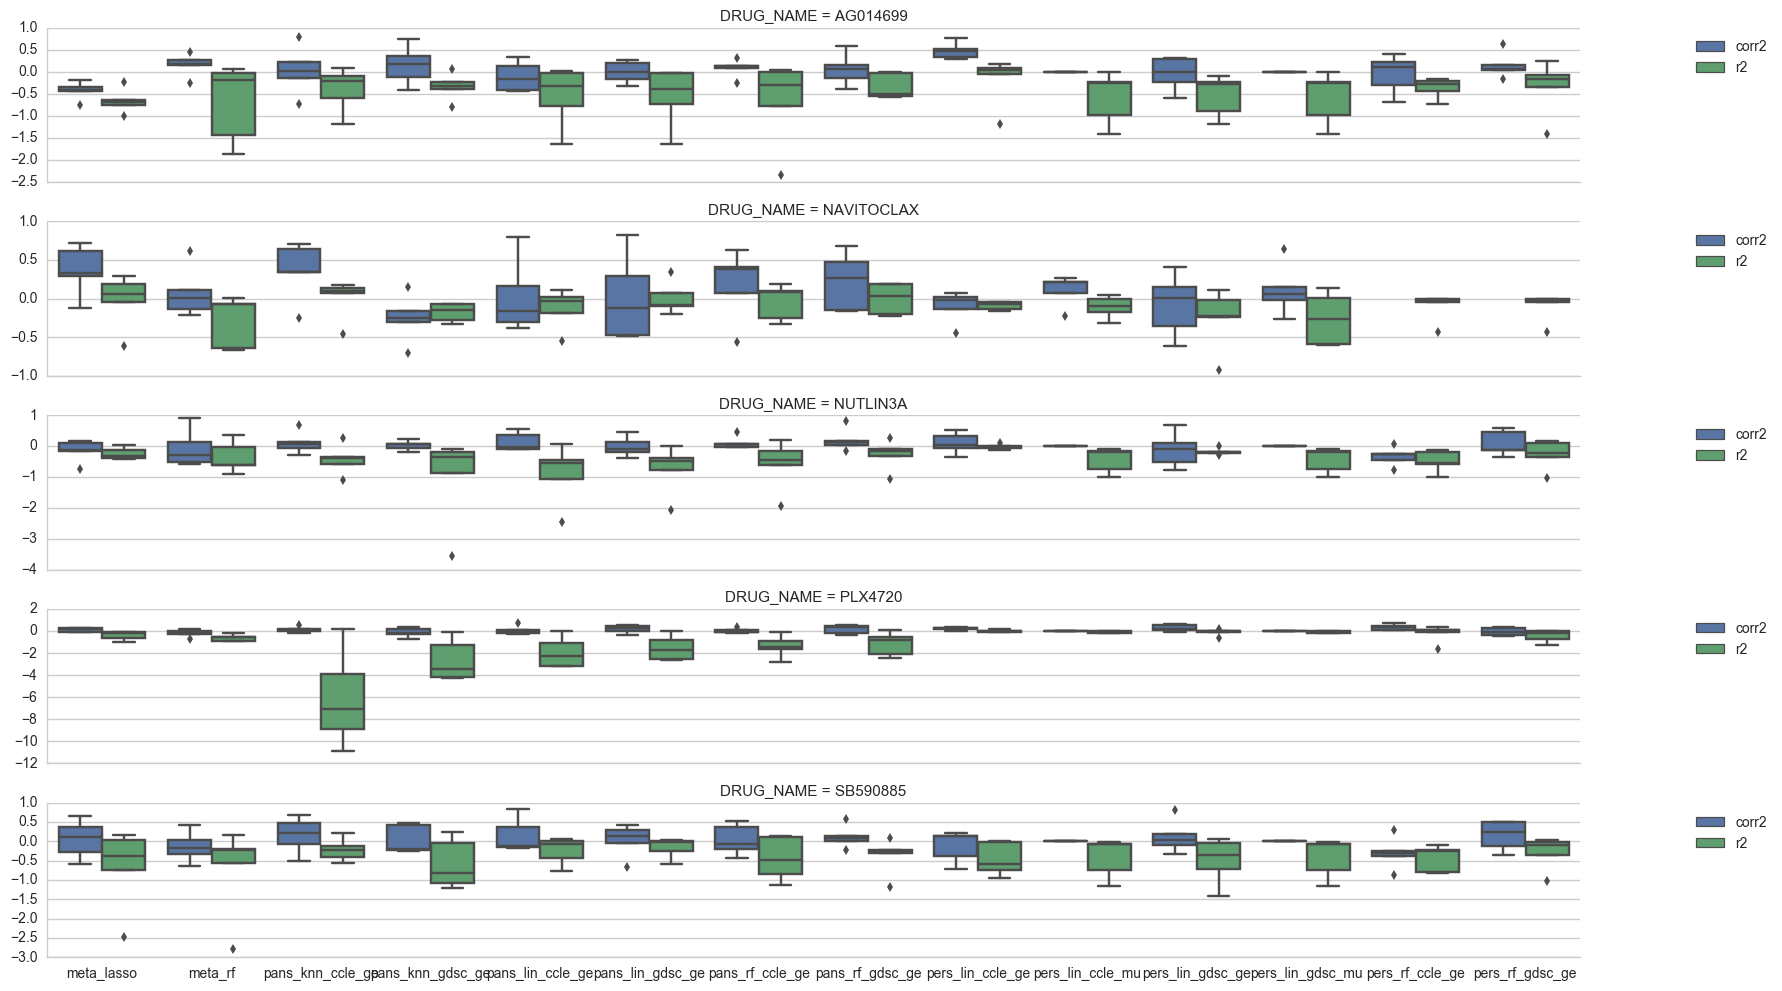

In [45]:
from sklearn.metrics import r2_score, mean_squared_error

def get_scores(d_pred, score_functions):
    c_actual = [c for c in d_pred if c[-1] == 'Actual']
    c_pred = d_pred.columns.difference(c_actual)
    d_score = []
    for c_act in c_actual:
        drug_name = c_act[-2]
        c_drug_pred = [c for c in c_pred if c[-2] == drug_name]
        for c_pre in c_drug_pred:
            model_name = c_pre[-1]
            def get_scores(g):
                g_sub = g[g[c_act].notnull()]
                return pd.Series({s:fn(g_sub[c_act], g_sub[c_pre]) for s, fn in score_functions.items()})
                    
            d = (
                d_pred[[c_pre, c_act]]
                .groupby(d_pred.index.get_level_values('FOLD_ID'))\
                .apply(get_scores)
            )
            d['DRUG_NAME'] = drug_name
            d['MODEL_NAME'] = model_name
            d_score.append(d)
            
    return pd.melt(
        pd.concat(d_score).reset_index(), 
        id_vars=['DRUG_NAME', 'MODEL_NAME', 'FOLD_ID'],
        value_name='VALUE', var_name='METRIC'
    )
        
def plot_scores(d_score, figsize=2, figaspect=5, legend_margin=(1.13, 1)):
    # Create a boxplot per task (in rows) with model names on the x axis and colors denoting metrics
    g = sns.FacetGrid(
        d_score, row='DRUG_NAME', size=figsize, aspect=figaspect, 
        legend_out=False, sharey=False
    )

    # Map grid to boxplot function
    def plot_data(*args, **kwargs):
        sns.boxplot(data=kwargs['data'], x='MODEL_NAME', y='VALUE', hue='METRIC')
    g.map_dataframe(plot_data)
    [ax.legend(bbox_to_anchor=legend_margin) for ax in g.axes.ravel()]


d_pred = res[site]['prediction_data']
score_functions = {
    'r2': r2_score,
    'corr2': lambda y_true, y_pred: y_pred.corr(y_true),
    #'mse': mean_squared_error
}
d_score = get_scores(d_pred, score_functions)
plot_scores(d_score, figaspect=8)

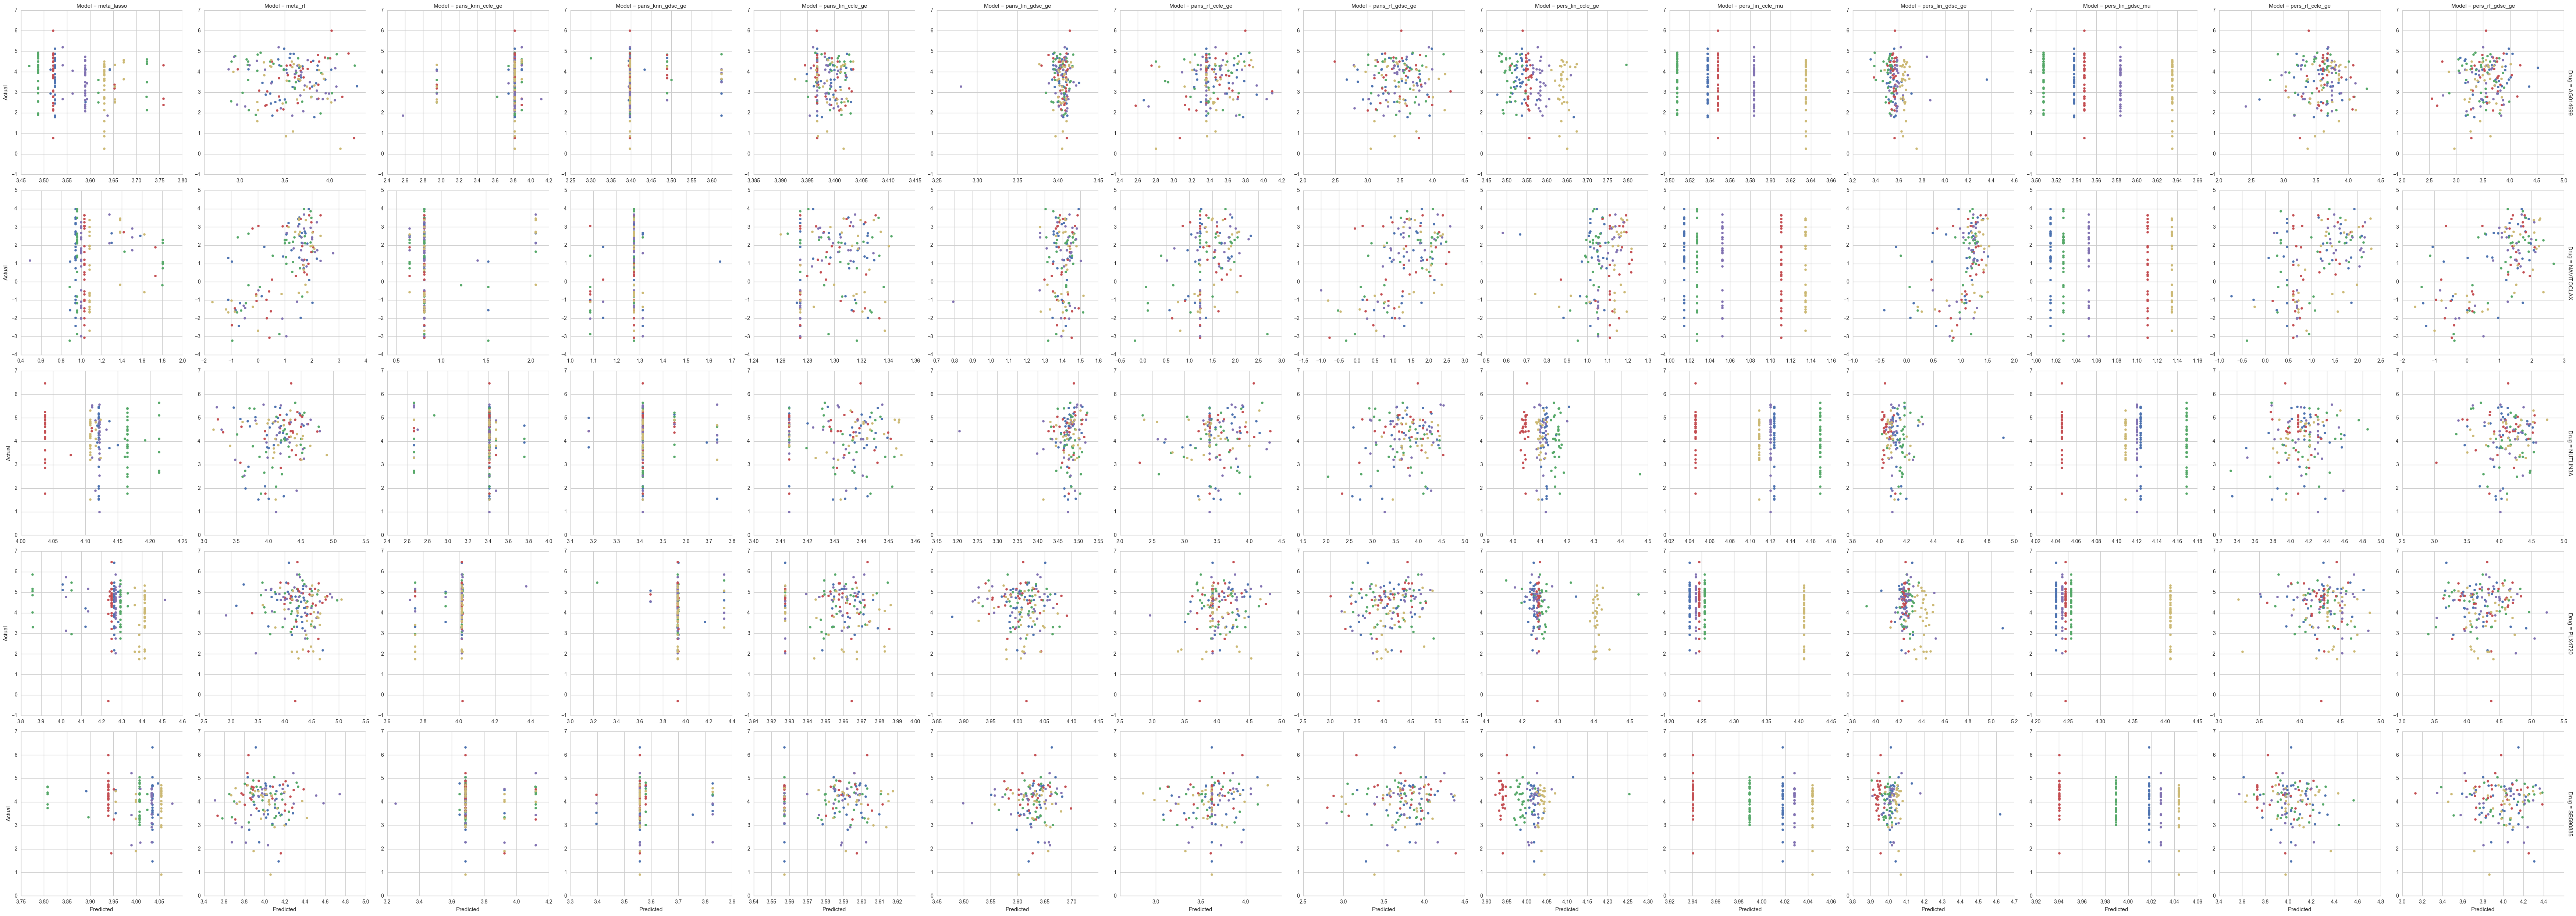

In [52]:

def plot_predictions(d_pred, share_axes=False):
    c_actual = [c for c in d_pred if c[-1] == 'Actual']
    c_pred = d_pred.columns.difference(c_actual)
    
    d = []
    for c_act in c_actual:
        drug_name = c_act[-2]
        c_drug_pred = [c for c in c_pred if c[-2] == drug_name]
        for c_pre in c_drug_pred:
            model_name = c_pre[-1]
            d.append(pd.DataFrame({
                'Predicted': d_pred[c_pre],
                'Actual': d_pred[c_act],
                'Drug': drug_name,
                'Model': model_name,
                'Fold': d_pred.index.get_level_values('FOLD_ID')
            }))
        
    d = pd.concat(d)
    g = sns.FacetGrid(
            d, row='Drug', col='Model', hue='Fold', margin_titles=True, size=5, aspect=1,
            sharex=share_axes, sharey=share_axes)
    #g.map(sns.regplot, 'Predicted', 'Actual')
    g.map(plt.scatter, 'Predicted', 'Actual')
    return g, d

grid, d_plt = plot_predictions(d_pred)

In [ ]:
sns.regplot

In [68]:
xx = np.arange(1, 10)
yx = xx * 1 + np.random.rand(len(xx))
r2_score(xx, yx)

0.97001348752971261